Phase Estimation Benchmark Program - Braket
... execution starting at Sep 20, 2024 03:27:17 UTC
************
Executing [2] circuits with num_qubits = 3
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 14, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 14, 0, 0
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.001, 0.016, 0.016 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 4
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 25, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 25, 0, 0
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.001, 0.029, 0.029 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 5
Average Circuit Algorithmic Depth, ξ (xi) for the 5 qubit group = 36, 0
Average Normalized

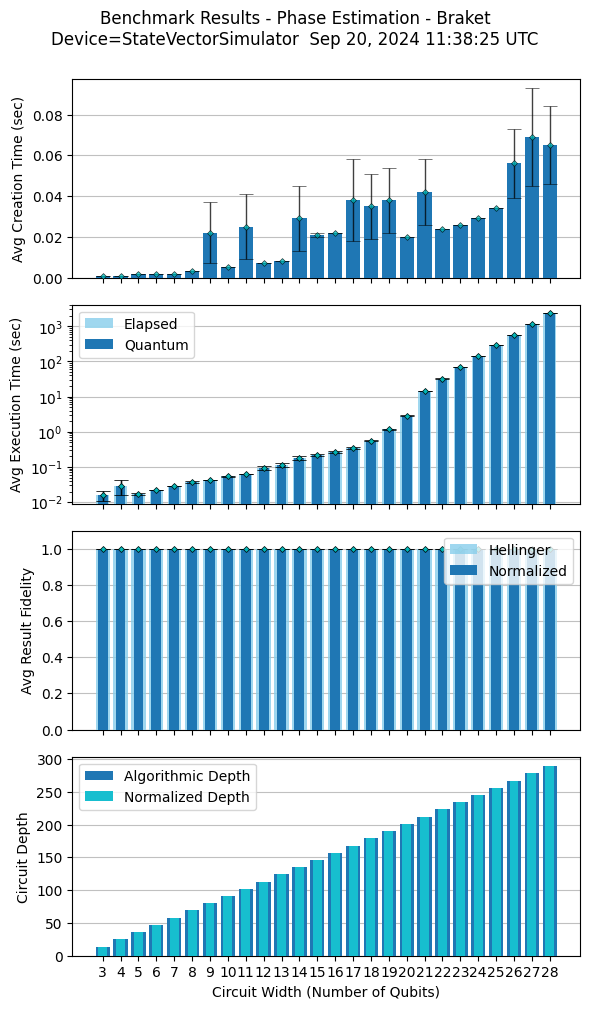

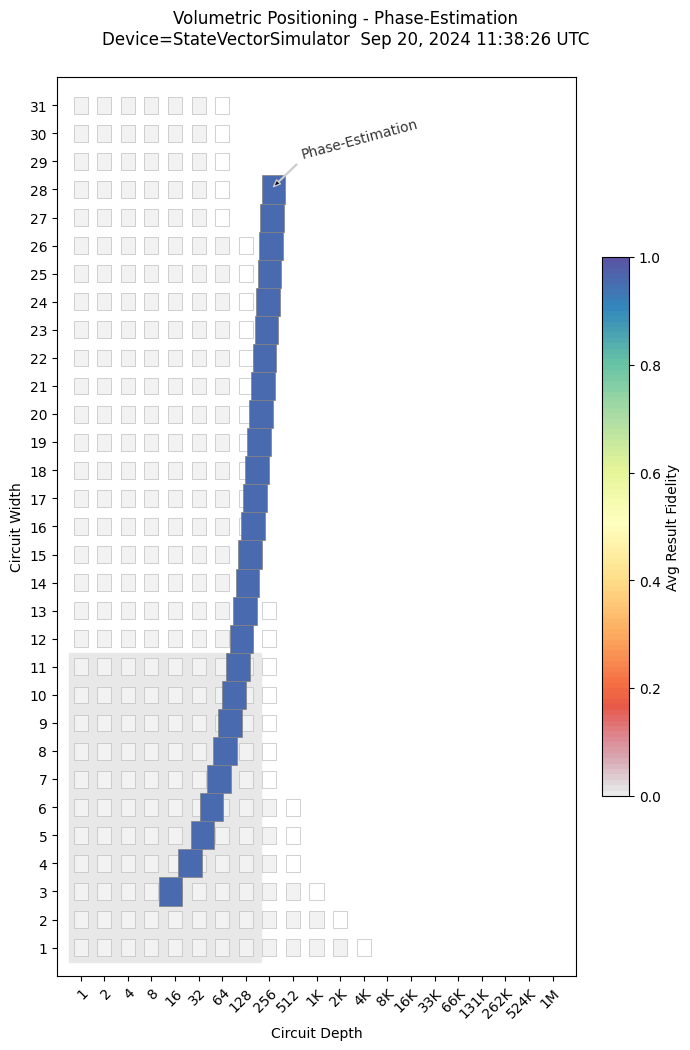

In [1]:
"""
Phase Estimation Benchmark Program - Braket
"""

import time
import sys

from braket.circuits import Circuit     # AWS imports: Import Braket SDK modules
import numpy as np

sys.path[1:1] = ["_common", "_common/braket", "quantum-fourier-transform/braket"]
sys.path[1:1] = ["../../_common", "../../_common/braket", "../../quantum-fourier-transform/braket"]
import execute as ex
import metrics as metrics
from qft_benchmark import inv_qft_gate

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
QFTI_ = None
U_ = None

############### Circuit Definition

def PhaseEstimation(num_qubits, theta):
    num_counting_qubits = num_qubits - 1 # only 1 state qubit
    
    qc = Circuit()
    
    # initialize counting qubits in superposition
    for i_qubit in range(num_counting_qubits):
         qc.h(i_qubit)
    
    # change to |1> in state qubit, so phase will be applied by cphase gate
    qc.x(num_counting_qubits)
    
    repeat = 1
    for j in reversed(range(num_counting_qubits)):
        # controlled operation: adds phase exp(i*2*pi*theta) to the state |1>
        #                       does nothing to state |0>
        # needs additional factor of 2 as crz has half the phase of cphase
        crz_gate(qc, 2*2*np.pi*theta*repeat, j, num_counting_qubits)
        repeat *= 2

    # inverse quantum Fourier transform only on counting qubits
    qfti = inv_qft_gate(num_counting_qubits)
    qc.add(qfti)
    
    # save smaller circuit example for display
    global QC_, U_, QFTI_
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
    #if U_ == None or num_qubits <= 5:
        #if num_qubits < 9: U_ = U
    if QFTI_ == None or num_qubits <= 5:
        if num_qubits < 9: QFTI_ = inv_qft_gate(num_counting_qubits)

    # return a handle on the circuit
    return qc       

############### CRZ shim

# Implement the CRZ with RZs and CNOTs
def crz_gate(qc, theta, control_qubit, target_qubit):
    qc.rz(target_qubit, theta/2)
    qc.cnot(control_qubit, target_qubit)
    qc.rz(target_qubit, -theta/2)
    qc.cnot(control_qubit, target_qubit)

############### Result Data Analysis

# Analyze and print measured results
def analyze_and_print_result (qc, result, num_counting_qubits, theta):

    # obtain shots from the result metadata
    num_shots = result.task_metadata.shots

    # obtain counts from the result object
    # for braket, need to reverse the key to match binary order
    # for braket, measures all qubits, so we have to remove data qubit measurement
    counts_r = result.measurement_counts
    counts_str = {}
    for measurement_r in counts_r.keys():
        measurement = measurement_r[:-1][::-1] # remove data qubit and reverse order
        if measurement in counts_str:
            counts_str[measurement] += counts_r[measurement_r]
        else:
            counts_str[measurement] = counts_r[measurement_r]

    # get results as times a particular theta was measured
    counts = bitstring_to_theta(counts_str, num_counting_qubits)
    if verbose: print(f"For theta value {theta}, measured thetas: {counts}")

    # correct distribution is measuring theta 100% of the time
    correct_dist = {theta: 1.0}
    correct_dist = {str(key): value for key, value in correct_dist.items()}   #convert the keys of the correct_dist dictionary into strings

    # generate thermal_dist with amplitudes instead, to be comparable to correct_dist
    bit_thermal_dist = metrics.uniform_dist(num_counting_qubits)
    thermal_dist = bitstring_to_theta(bit_thermal_dist, num_counting_qubits)

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist, thermal_dist)
    
    return counts, fidelity

def bitstring_to_theta(counts, num_counting_qubits):
    theta_counts = {}
    for key in counts.keys():
        r = counts[key]
        theta = int(key,2) / (2**num_counting_qubits)
        if theta not in theta_counts.keys():
            theta_counts[theta] = 0
        theta_counts[theta] += r
    return theta_counts

################ Benchmark Loop
        
# Execute program with default parameters
def run(min_qubits=3, max_qubits=28, max_circuits=3, num_shots=1000,
        backend_id='simulator'):

    print("Phase Estimation Benchmark Program - Braket")

    num_state_qubits = 1 # default, not exposed to users, cannot be changed in current implementation

    # validate parameters (smallest circuit is 3 qubits)
    max_qubits = max(3, max_qubits)
    min_qubits = min(max(3, min_qubits), max_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # Initialize metrics module
    metrics.init_metrics()
    
    # Define custom result handler
    def execution_handler (qc, result, num_qubits, theta):  
     
        # determine fidelity of result set
        num_counting_qubits = int(num_qubits) - 1
        counts, fidelity = analyze_and_print_result(qc, result, num_counting_qubits, float(theta))
        metrics.store_metric(num_qubits, theta, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id)

    # # for noiseless simulation, set noise model to be None
    # ex.set_noise_model(None)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1):
    
        # as circuit width grows, the number of counting qubits is increased
        num_counting_qubits = num_qubits - num_state_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2**(num_counting_qubits), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # generate theta to always be a multiple of 1/2^N
        theta = np.random.choice(2**(num_counting_qubits)) / 2**(num_counting_qubits)

        # determine range of secret strings to loop over
        if 2**(num_counting_qubits) <= max_circuits:
            theta_range = [i/(2**(num_counting_qubits)) for i in list(range(num_circuits))]
        else:
            theta_range = [i/(2**(num_counting_qubits)) for i in np.random.choice(2**(num_counting_qubits), num_circuits, False)]

        # loop over limited # of random theta choices
        for theta in theta_range:
            # create the circuit for given qubit size and theta, store time metric
            ts = time.time()

            qc = PhaseEstimation(num_qubits, theta)
            metrics.store_metric(num_qubits, theta, 'create_time', time.time() - ts)

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, theta, num_shots)
        
        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    #ex.execute_circuits()
    #metrics.aggregate_metrics_for_group(num_qubits)
    #metrics.report_metrics_for_group(num_qubits)

    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nInverse QFT Circuit ="); print(QFTI_ if QFTI_ != None else "  ... too large!")


    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Phase Estimation - Braket")

# if main, execute method
if __name__ == '__main__': run()
   
